# Demontration of neural network MCMC sampler trained with maximum Entropy objective 


## Please run Cells in the order provided.

Requirements: pytorch 1.6.0 (cuda not required), numpy, matplotlib

### First we import modules and setup the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from L2RW_models import L2GradRW, CovMALA
from L2RW import L2GradRW_M, adjust_lr
from distributions import distributions

In [2]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('moon',d=data_dim)
RW = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=0.01,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller = L2GradRW_M(RW,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=5000)

### Train the Sampler

sldjxx is the proposal entropy (up to a constant equal to the entropy of Gaussian), it should increase during training

In [ ]:
#train with real samples
bs = 512
for i in range(5000):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

jump 1.037e-04, Exp jump1.037e-04, accept 1.000,log_a -3.993e-08, sldjxx -9.210,beta 1.010e-02, epsi 1.001e-02
jump 6.055e-03, Exp jump5.980e-03, accept 0.986,log_a 1.601e-03, sldjxx -5.229,beta 2.582e-02, epsi 1.109e-02
jump 2.731e-01, Exp jump2.656e-01, accept 0.977,log_a -3.083e-03, sldjxx -1.637,beta 5.887e-02, epsi 1.220e-02
jump 9.075e-01, Exp jump8.443e-01, accept 0.966,log_a -1.321e-02, sldjxx -0.957,beta 1.169e-01, epsi 1.279e-02
jump 1.253e+00, Exp jump1.192e+00, accept 0.956,log_a -9.037e-03, sldjxx -0.679,beta 2.136e-01, epsi 1.295e-02
jump 1.900e+00, Exp jump1.595e+00, accept 0.919,log_a -5.071e-02, sldjxx -0.347,beta 3.186e-01, epsi 1.310e-02
jump 2.672e+00, Exp jump2.032e+00, accept 0.910,log_a -8.190e-02, sldjxx -0.270,beta 3.766e-01, epsi 1.318e-02
jump 3.502e+00, Exp jump2.775e+00, accept 0.892,log_a -4.817e-02, sldjxx -0.089,beta 3.937e-01, epsi 1.325e-02
jump 3.447e+00, Exp jump2.812e+00, accept 0.910,log_a -4.692e-02, sldjxx -0.065,beta 4.050e-01, epsi 1.326e-02
ju

### Visualize learned proposal distribution

Yellow dot is initial point, blue dots are accepted samples, black are rejected ones.

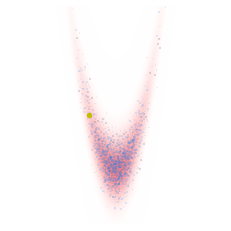

In [4]:
bs = 4096
x_init = torch.tensor([-2.,0.]).view(1,-1) #x at an extreme location, similar to Figure in the paper
#x_init = dist.sample(1) #Use this line for a random point from the distribution
x = x_init.expand((bs,data_dim)).clone()
xa, xp, accept_vect,_ = RW_controller.sample(x.clone(),1,grad=False,T=1)

plot_range = 8
res = 1024
Temp = 2 #temperature for better visuals
dist2d = dist
Eplot = dist2d.Ex
x = np.linspace(-plot_range,plot_range,res)
xx,yy = np.meshgrid(x,x)
xy_batch = np.stack([xx.flatten(),yy.flatten()],axis=1)
Exy = Eplot(torch.from_numpy(xy_batch).float())/Temp
Exy = Exy - Exy.min()
p_batch = (-Exy).exp().numpy()
p_batch = p_batch/p_batch.max()
p_batch = np.flip(p_batch.reshape(res,res),axis=0)

bkg_img = 1 - np.stack((0*p_batch,0.5*p_batch,0.5*p_batch),axis=2)


x_init_np = x_init.detach().cpu().numpy()
xp_np = xp.detach().cpu().numpy()
c_vect = accept_vect.detach().cpu().float().numpy()
c_vect = np.stack((0*c_vect,0.5*c_vect,1*c_vect),axis=1)
#xp_np = torch.randn_like(xp).cpu().numpy()
fig, ax = plt.subplots()
ax.imshow(bkg_img,extent=[-plot_range,plot_range,-plot_range,plot_range])
ax.scatter(xp_np[:,0],xp_np[:,1],s = 0.15,c=c_vect,alpha=0.1,marker=',')
ax.scatter(x_init_np[:,0],x_init_np[:,1],s=20,c='y')
ax.set_aspect(1)
ax.set_xlim(-plot_range,plot_range)
ax.set_ylim(-plot_range,plot_range)
ax.set_axis_off()
plt.show()

### Sample contimuously for 1000 steps

In [30]:
bs = 1024
x = dist.sample(bs)
x_list = []
for i in range(1000):
    x,xp,accept_vect,_ = RW_controller.sample(x,1,grad=False,print_log= True if i%100==0 else False,)
    x_list.append(x.clone())

accept 0.8984375
accept 0.9072265625
accept 0.9033203125
accept 0.9111328125
accept 0.9052734375
accept 0.896484375
accept 0.904296875
accept 0.8955078125
accept 0.8896484375
accept 0.9033203125


### Visualize distribution in the batch at the last time point

Should see fair samples from the moon distribution

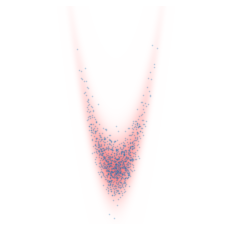

In [33]:
xp_np = x_list[-1].detach().cpu().numpy()
fig, ax = plt.subplots()
ax.imshow(bkg_img,extent=[-plot_range,plot_range,-plot_range,plot_range])
ax.scatter(xp_np[:,0],xp_np[:,1],s = 0.6,alpha=0.2)
ax.set_aspect(1)
ax.set_xlim(-plot_range,plot_range)
ax.set_ylim(-plot_range,plot_range)
ax.set_axis_off()
plt.show()

### Visualize the evolution of first dimension (horizontal axis), 

Should be a Gaussian with little correlation.

In [1]:
batch_i = 159
visualize_dim = 0 #change to 1 for the vertical axis
y_vect = torch.stack(x_list,dim=0)[0:,batch_i,visualize_dim].detach().cpu().numpy()
fig, ax = plt.subplots()
ax.plot(y_vect,'.')
y_mean, y_std = y_vect.mean(), y_vect.std()
print('y mean {}, y std {}'.format(y_mean.item(), y_std.item()))

NameError: name 'torch' is not defined